In [268]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import optimize

from process_opendata import athlete, performance_fxns

In [5]:
sample_open_data_ath = "E:\gc_opendata\9787e81f-19f6-4cc1-891d-63e68b4d2f9f"
sample_open_data_ath = '/Users/ryanduecker/git/athletics/TriNet/gc_opendata-samples/618af747-d5d6-45e1-9efc-aaa1dd2d6cf0'

In [7]:
ath0 = athlete(root_dir=sample_open_data_ath)
ath0.get_activity_metadata()


'Metadata processed'

In [8]:
max_array = 0
dim_array = 0
all_activity_arrays = []
for activity_filepath in ath0.athlete_activity_filepaths:
    activity_array = ath0.extract_activity(activity_filepath=activity_filepath, make_xspeed=True)
    if activity_array.shape[1] > max_array:
        max_array = activity_array.shape[1]
    if activity_array.shape[0] > dim_array:
        dim_array = activity_array.shape[0]
    activity_datetime_str = os.path.split(activity_filepath)[-1]
    activity_datetime = datetime.datetime.strptime(activity_datetime_str, '%Y_%m_%d_%H_%M_%S.csv')
    all_activity_arrays.append({'activity_dt':activity_datetime,'data_array':activity_array})

/var/folders/gn/wxd67cbn51d8ncyr2z2nkfzh0000gn/T/ipykernel_9405/1540811501.py:19: RuntimeWarning: invalid value encountered in true_divide
  ,(x[elev_id,1:] - x[elev_id,:-1]) /     # delta alt
/var/folders/gn/wxd67cbn51d8ncyr2z2nkfzh0000gn/T/ipykernel_9405/1540811501.py:19: RuntimeWarning: invalid value encountered in true_divide
  ,(x[elev_id,1:] - x[elev_id,:-1]) /     # delta alt
/var/folders/gn/wxd67cbn51d8ncyr2z2nkfzh0000gn/T/ipykernel_9405/1540811501.py:19: RuntimeWarning: invalid value encountered in true_divide
  ,(x[elev_id,1:] - x[elev_id,:-1]) /     # delta alt
/var/folders/gn/wxd67cbn51d8ncyr2z2nkfzh0000gn/T/ipykernel_9405/1540811501.py:19: RuntimeWarning: invalid value encountered in true_divide
  ,(x[elev_id,1:] - x[elev_id,:-1]) /     # delta alt
/var/folders/gn/wxd67cbn51d8ncyr2z2nkfzh0000gn/T/ipykernel_9405/1540811501.py:19: RuntimeWarning: invalid value encountered in true_divide
  ,(x[elev_id,1:] - x[elev_id,:-1]) /     # delta alt
/var/folders/gn/wxd67cbn51d8ncyr2z2

In [9]:
# metadata_hr_offset = (((ath0.activity_metadata[0]['activity_dt'] - all_activity_arrays[0]['activity_dt']).seconds/60/60) +
#                       ((ath0.activity_metadata[0]['activity_dt'] - all_activity_arrays[0]['activity_dt']).days * 24))
# (ath0.activity_metadata[0]['activity_dt'] - all_activity_arrays[0]['activity_dt']).days

## Focused data explore

In [132]:
def calc_vo2(row, athlete_statics):
    if row['sport'] == 'Bike':
        percent_vo2 = (row['METRICS.average_hr'] - athlete_statics["resting_hr"])/(athlete_statics["max_hr"] - athlete_statics["resting_hr"])
        vo2_estimated = (((row['METRICS.average_power']/75)*1000)/row['METRICS.athlete_weight']) / percent_vo2
    elif row['sport'] == 'Run':
        percent_vo2 = (row['METRICS.average_hr'] - athlete_statics["resting_hr"])/(athlete_statics["max_hr"] - athlete_statics["resting_hr"])
        vo2_estimated = (210/row['xPace']) / percent_vo2
    else:
        vo2_estimated =  0
    return vo2_estimated

def use_garmin_vo2(row, athlete_statics):
    vo2_estimated = 0
    if (row['Workout_Code'] != 'Rec') & (row['Sport'] in ['Run','Bike']):
        vo2_estimated = row['VO2max_detected'] # Garmin VO2 Estimation
    return vo2_estimated

def calc_ae_ef(row, athlete_statics):
    ef = 0
    if (row['Workout_Code'] == 'AE'):
        if row['Sport'] == 'Bike':
            ef = row['IsoPower']/row['METRICS.average_hr']
        elif row['Sport'] == 'Run':
            ef = row['IsoPower']/row['METRICS.average_hr']
    return ef

def use_power_index(row, athlete_statics):
    if row['Average_Power'] > 0:
        val = row['Power_Index']
    else:
        val = 0
    return val

def use_power_index_ef(row, athlete_statics):
    if row['Average_Power'] > 0:
        hr_range = athlete_statics['max_hr'] - athlete_statics['resting_hr']
        avg_hr_rel = row['Average_Heart_Rate'] - athlete_statics['resting_hr']
        relative_hr = (avg_hr_rel / hr_range)*100
        
        pi_ef = row['Power_Index']/relative_hr
        val = pi_ef
    else:
        val = 0
    return val

def modeled_aerobic_threshold_power(row, athlete_statics):
    temp = 20
    duration = 60*60
    
    if (row['a'] != 0) & (row['Duration'] > 999):
        power = row['a'] + row['b']*athlete_statics['threshold_hr'] +  row['c']*duration*temp
        return power
    else:
        return 0

performance_fxns = [calc_vo2, use_garmin_vo2, calc_ae_ef, use_power_index, use_power_index_ef, modeled_aerobic_threshold_power]

In [251]:
def pre_process(data_df, performance_fxn, performance_lower_bound=0, sport=False):
    data_df['date'] = pd.to_datetime(data_df['date'].apply(lambda x: x.split(' ')[0]))
    data_df['xPace'] = np.where(data_df['METRICS.xPace_safe'].astype(float) <= 0, data_df['METRICS.pace'].astype(float), data_df['METRICS.xPace_safe'].astype(float))
    data_df['METRICS.average_power'] = data_df['METRICS.average_power'].apply(lambda x: float(x[0]) if type(x) == list else np.nan)
    data_df['METRICS.average_hr'] = data_df['METRICS.average_hr'].apply(lambda x: float(x[0]) if type(x) == list else np.nan)
    data_df['METRICS.athlete_weight'] = data_df['METRICS.athlete_weight'].apply(lambda x: float(x))

    data_df = data_df[~(((data_df['sport'] == 'Run') & (data_df['METRICS.pace'].astype(float) <= 0))
                | ((data_df['sport'] == 'Bike') & (data_df['METRICS.average_power'].astype(float) <= 0))
                | (data_df['METRICS.average_hr'].astype(float) <= 0))].copy()
    data_df.rename(columns={'date':'workoutDate'}, inplace=True)
    data_df['METRICS.triscore'] = data_df['METRICS.triscore'].astype(float)
    data_df['day_TSS'] = data_df['METRICS.triscore'].groupby(data_df['workoutDate']).transform('sum').fillna(0)
    data_df['performance_metric'] = data_df.apply(lambda row: performance_fxn(row, athlete_statics), axis=1)

    data_df['performance_metric'] = np.where(data_df['performance_metric'] < performance_lower_bound, 0, data_df['performance_metric'])
    data_df['performance_metric'] = data_df['performance_metric'].replace(0,np.nan)
    data_df['performance_metric'] = data_df['performance_metric'].fillna(method='ffill')

    agg_dict = {'day_TSS':'mean','performance_metric':'max'}
    if sport:
        agg_dict.update({'sport':'first'})
        data_df = data_df.sort_values('sport')
    data_df = data_df.groupby('workoutDate').agg(agg_dict)

    data_df['date'] = data_df.index
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df = data_df.sort_values(by=['date'])
    data_df.index = pd.DatetimeIndex(data_df['date'])

    missing_dates = pd.date_range(start=data_df.index.min(), end=data_df.index.max())
    data_df = data_df.reindex(missing_dates)

    data_df['performance_metric'] = data_df['performance_metric'].replace(0,np.nan)
    # data_df['performance_metric'] = data_df['performance_metric'].fillna(method='ffill')
    data_df = data_df.dropna()
    return data_df

In [234]:
with open(ath0.athlete_summary_file,'r') as f:
    ath_sum = f.read()
    f.close()
ath_sum_l = json.loads(ath_sum)

In [235]:
ath_sum_df = pd.json_normalize(ath_sum_l['RIDES'])

<AxesSubplot:ylabel='Frequency'>

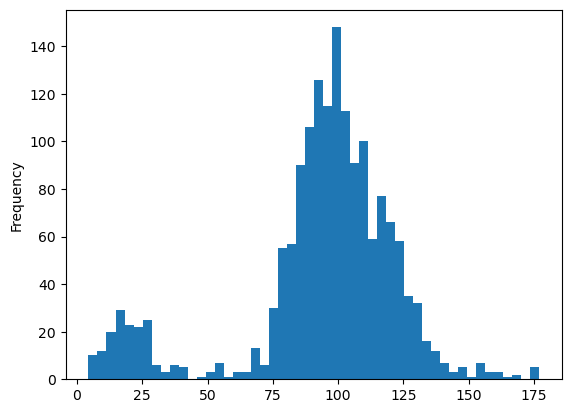

In [236]:
mins = ath_sum_df['METRICS.min_heartrate'].dropna().astype(float)
mins.plot(kind='hist',bins=50)

In [237]:
max_hr = ath_sum_df['METRICS.max_heartrate'].astype(float).dropna().quantile(.99)
rhr = 49

athlete_statics = {'max_hr': max_hr,
                   'resting_hr':rhr}


In [238]:
def pull_justx(val):
    try:
        return float(val[0])
    except:
        return np.nan
ath_sum_df['METRICS.xPace_safe'] = ath_sum_df['METRICS.xPace'].apply(pull_justx)

## Scipy Solver

In [256]:
class banister(object):
    def __init__(self, params=[0.1, 0.5, 50, 45, 7], ctlatl_start=0):
        self.params = params
        self.ctls = []
        self.atls = []
        self.ctlatl_start = [ctlatl_start]
    
    def model(self, load_metric, params=[]):
        if len(params) != 5:
            params = self.params
        self.params = params
        
        self.ctls = self.atls = self.ctlatl_start # why?
        Banister_Predictions = np.array([])
        for i in range(len(load_metric)):
            ctl = (load_metric[i] * (1-math.exp(-1/params[3]))) + (self.ctls[i] * (math.exp(-1/params[3])))
            atl = (load_metric[i] * (1-math.exp(-1/params[4]))) + (self.atls[i] * (math.exp(-1/params[4])))
            self.ctls.append(ctl)
            self.atls.append(atl)
            Banister_Predictions = np.append(Banister_Predictions, params[2] + params[0]*ctl - params[1]*atl)

        return Banister_Predictions

In [269]:
ath_sum_dfb[ath_sum_df['METRICS.triscore'].astype(float) > 0].shape[0]/ath_sum_df.shape[0]

NameError: name 'ath_sum_dfb' is not defined

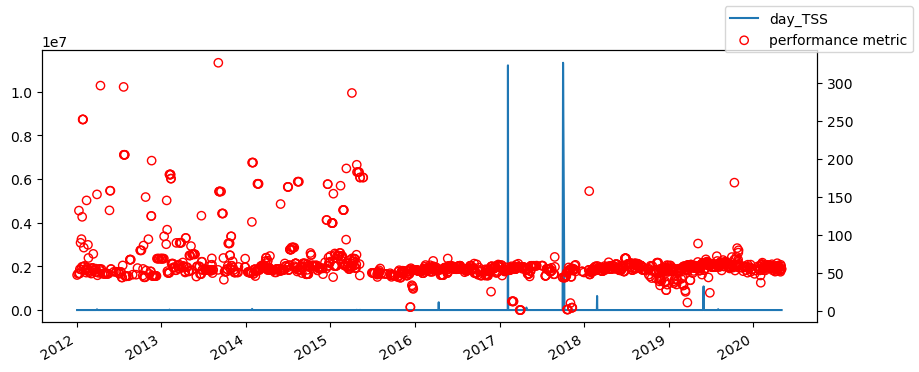

In [270]:
ctls_ref = 42
atls_ref = 7
performance_fxn = calc_vo2


data_pre = ath_sum_df.copy()

data = pre_process(data_pre, performance_fxn=performance_fxn, sport=False)
load_metric = data['day_TSS'].to_numpy()
performance_metric = data['performance_metric'].to_numpy()
fig, ax = plt.subplots(figsize=(10,4))
data['day_TSS'].plot(ax=ax)#.rolling(window=7,min_periods=1).sum().plot(ax=ax)
ax2 = ax.twinx()
ax2.scatter(data.index
            ,data['performance_metric']#.rolling(window=1, min_periods=1).max()
            ,marker='o'
            ,edgecolor='red'
            ,facecolor='none'
            ,label='performance metric'
            )
fig.legend()

In [271]:
data['performance_metric'].quantile(.95)

119.56750229649869

In [282]:
bm = banister()

def optimize_banister(params):    
    losses = []

    Banister_Predictions = bm.model(load_metric, params=params)
    
    losses = abs(performance_metric - Banister_Predictions)
    MAE = np.mean(losses)
    return MAE

initial_guess  = [.5, .5, 55, 45, 7]
individual_banister_model = optimize.minimize(optimize_banister
                                            ,x0=initial_guess
                                                #     k1,       k2,       p0,     CTLS,   ATLS
                                            ,bounds=[(.1,1.00),(.05,1.0),(50,60),(30,50),(5,12)]
                                            # ,method='Nelder-Mead'
                                            # ,tol=1e-8
                                            )
print(individual_banister_model)
for val in individual_banister_model['x']:
    print(val)

      fun: 24.08760318815069
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.21759717e+02,  9.23522245e+02,  4.47529621e-01,  1.84149996e+00,
       -4.49122693e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 942
      nit: 26
     njev: 157
   status: 0
  success: True
        x: array([1.21892205e-01, 5.00000000e-02, 5.38653690e+01, 3.00000000e+01,
       1.19995077e+01])
0.12189220498879325
0.05
53.86536901967865
30.000000008674373
11.999507667468961


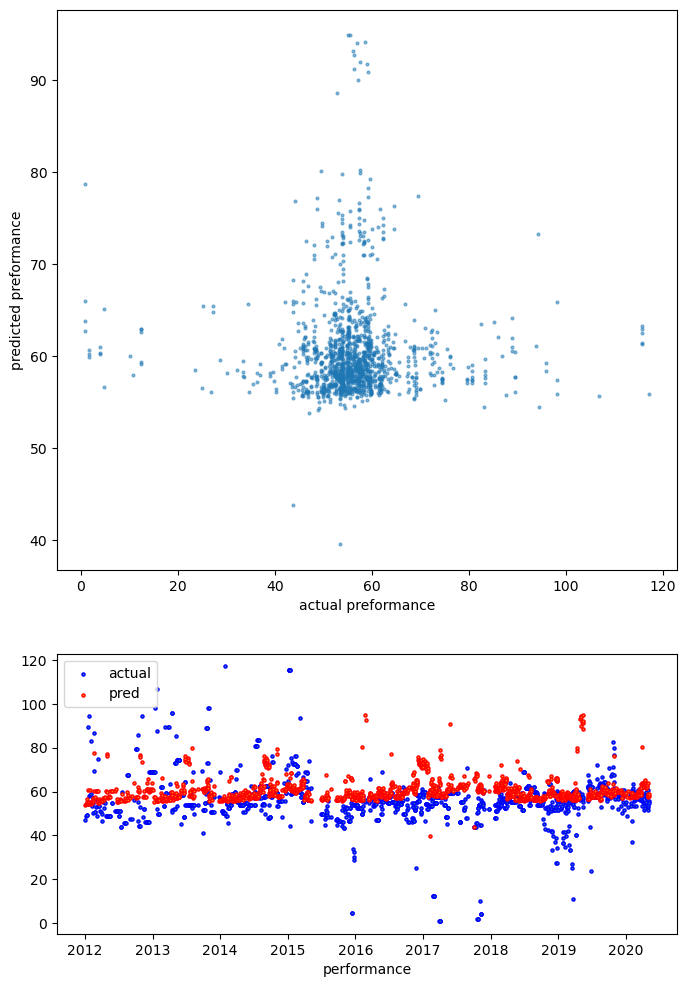

In [283]:
load_metric = data['day_TSS'].tolist()
data['pred_performance_metric'] = bm.model(load_metric)

p_data = data[(data['performance_metric']<data['performance_metric'].quantile(.95)) 
             &(data['pred_performance_metric']<data['pred_performance_metric'].quantile(.95)) ]

## Plot
fig, ax = plt.subplots(2,1, figsize=(8,12), dpi=100,  gridspec_kw={'height_ratios': [2, 1]})
ax[0].scatter(x=p_data['performance_metric']
          ,y=p_data['pred_performance_metric']
          ,s=4
          ,alpha=.5)
ax[0].set_xlabel('actual preformance')
ax[0].set_ylabel('predicted preformance')

ax[1].scatter(p_data.index
             ,p_data['performance_metric']
             ,label='actual'
             ,facecolor=None
             ,edgecolor='blue'
             ,s=5
             ,linewidths=1
             ,marker='o')
ax[1].scatter(p_data.index
             ,p_data['pred_performance_metric']
             ,label='pred'
             ,facecolor=None
             ,edgecolor='red'
             ,s=5
             ,linewidths=1
             ,marker='o')
ax[1].set_xlabel('date')
ax[1].set_xlabel('performance')
ax[1].legend(loc=2)

## NN

In [ ]:
for activ_array in all_activity_arrays:
    activ_array

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.hidden_1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.output = nn.Linear(in_features=16, out_features=output_dim)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        return self.output(x)
    
    
model = Net()
print(model)

In [ ]:
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    # Train set
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )
    
    # Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )